In [1]:
import pandas as pd
import numpy as np
from ksif import Portfolio
from scipy.optimize import minimize

pf = Portfolio()

firm_need={'삼성전자':True,'SK하이닉스':True,'NAVER':True}
pf['label']=pf['firmname'].map(firm_need)

pf_need=pf[(pf['date']>'2015-04') & (pf['label']==True)][['firmname','date','ret_1m']]

In [6]:
#a) Find annualized arithmetic average and variance of excess return for the stocks you have chosen.

mean_firm=pf_need.groupby('firmname').mean().T

var_firm=pf_need.groupby('firmname').var().T

#mean_firm

var_firm


firmname,NAVER,SK하이닉스,삼성전자
ret_1m,0.007378,0.008229,0.005027


In [7]:
#b) Find variance-covariance matrix of 3 stocks’ returns.
dic={}
for i in list(pf_need['firmname'].unique()):
    dic[i]=list(pf_need[pf_need['firmname']==i]['ret_1m'])

data_f_all=pd.DataFrame(dic)
cov_matrix=pd.DataFrame.cov(data_f_all)

cov_matrix=cov_matrix[list(mean_firm.columns)]
cov_matrix=cov_matrix.loc[list(mean_firm.columns),:]
cov_matrix

,NAVER,SK하이닉스,삼성전자
NAVER,0.007378,0.000941,0.002384
SK하이닉스,0.000941,0.008229,0.003367
삼성전자,0.002384,0.003367,0.005027


In [23]:
#weight generating
number_of_firm=3
number_if_iter=5000
one_company_more_than_20=True

weight_frame=pd.DataFrame()
    
for i in range(number_if_iter):
    ran_list = np.random.random(number_of_firm)
    ran_list /= ran_list.sum()
    weight_frame=weight_frame.append(pd.DataFrame(ran_list).T)
    
weight_frame.columns=[('weight'+'_'+list(mean_firm.columns)[i]) for i in range(number_of_firm)]

if(one_company_more_than_20):
    weight_frame=weight_frame[weight_frame.iloc[:,0]>0.2]
    weight_frame
else:
    weight_frame


In [24]:
def portfolio_mean(x):
    return(sum(np.array(mean_firm.iloc[0,:])*np.array(x)))

def portfolio_sd(x):
    temp_mat=np.dot(np.array(x),cov_matrix)
    return(np.dot(temp_mat,np.array(x).T)** 0.5)

return_mean = weight_frame.apply(portfolio_mean,axis=1)
return_variance = weight_frame.apply(portfolio_sd,axis=1)

weight_frame['return_mean']=return_mean
weight_frame['return_variance']=return_variance


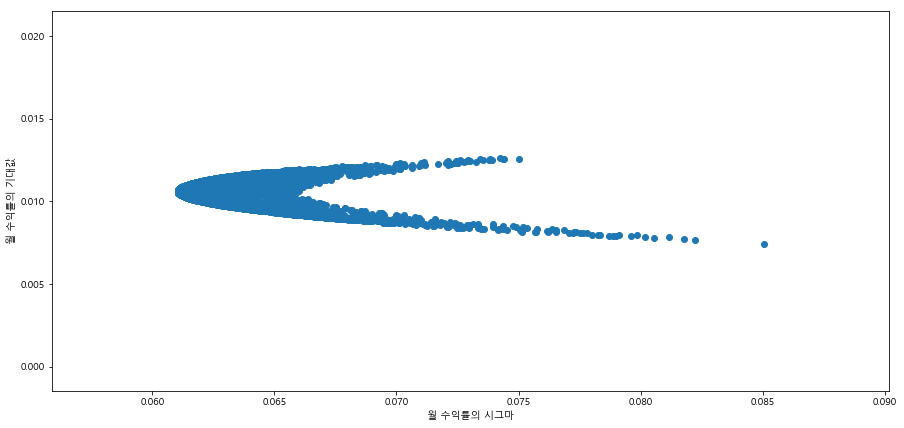

In [25]:
import matplotlib.pyplot as plt


# set label of axes
plt.figure(figsize=(15,7))
plt.xlabel('월 수익률의 시그마')
plt.ylabel('월 수익률의 기대값')

# plot
plt.scatter(weight_frame['return_variance'],weight_frame['return_mean'] )
plt.show()


In [26]:
#Optimize weight for best sharpe ratio
risk_free=0.001

def objective(x):
    return (-(portfolio_mean(x)-risk_free)/portfolio_sd(x))
    
def constraint(x):
    sum_sq=1
    sum_sq=sum_sq-sum(x)
    return sum_sq

if one_company_more_than_20 :
    a=(0.2,1.0)
    b=(0.0,1.0)
    bnds = (a,b,b)
else:
    b=(0.0,1.0)
    bnds = (b,b,b)   

In [27]:
x0=[0.5,0.2,0.3]
cons={'type':'eq','fun':constraint}

In [28]:
tangent_portfolio=minimize(objective,x0,method='SLSQP',bounds=bnds,constraints=cons)

In [29]:
tangent_portfolio

     fun: -0.16710162723883365
     jac: array([-0.00161128, -0.01922725, -0.01918819])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.2       , 0.41768815, 0.38231185])

In [33]:
tangent_mean=portfolio_mean(list(tangent_portfolio.x))
tangent_sd=portfolio_sd(list(tangent_portfolio.x))
tangent_sd

0.06373843275028492

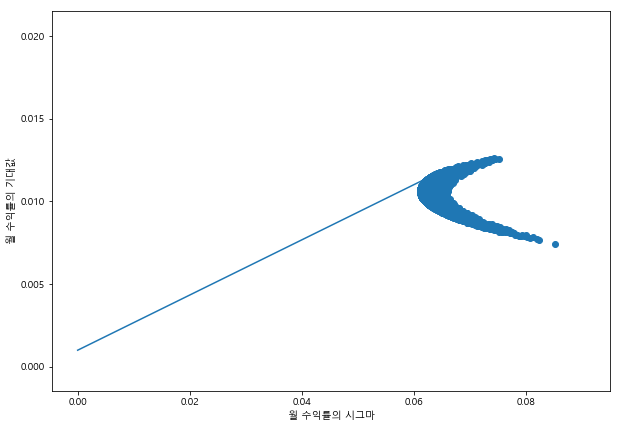

In [31]:
# set label of axes
plt.figure(figsize=(10,7))
plt.xlabel('월 수익률의 시그마')
plt.ylabel('월 수익률의 기대값')


# plot
plt.scatter(weight_frame['return_variance'],weight_frame['return_mean'] )
plt.plot([0,tangent_sd],[risk_free,tangent_mean])
plt.show()


In [34]:
tangent_weight=list(tangent_portfolio.x)

In [35]:
def portfolio_history_mean_by_tangent_w(x):
    return(sum(np.array(tangent_weight)*np.array(x)))

history_return=data_f_all.apply(portfolio_history_mean_by_tangent_w,axis=1)
history_return=history_return.sort_values(ascending=True)
history_return=list(history_return)

In [47]:
var_5=tangent_mean-1.65*tangent_sd
var_5

-0.09351761820774453

In [48]:
expected_shortfall=sum(history_return[0:int(len(history_return)*5/100)])/int(len(history_return)*5/100)
expected_shortfall

-0.11289604687048377

In [64]:
risk_aversion=5
(tangent_mean-risk_free)/((risk_aversion)*tangent_sd**2)

0.5243355383195759

0.001